## Polish stock market indicies analysis with Deep Learning models 

In [1]:
# I begin with some standard imports
import math
import os
import sys
import time
import numpy as np
import pandas as pd
import quantstats as qs
import random as rn
import matplotlib.pyplot as plt
import scipy.stats as scs
%matplotlib inline
%config InLineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# Sci-kit learn imports (for shallow learning)
import sklearn
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 

In [4]:
# Tensorflow and Keras imports (for deep learning)
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.initializers import random_normal
from keras.layers import Dense, Dropout, SimpleRNN, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.optimizers import Adam

In [5]:
# Some Matplotlib and Seaborn settings to standardize the figures in the notebook 
plt.rcParams["figure.dpi"] = 75
plt.style.use("seaborn-v0_8")

In [6]:
# I define a seed function to set all seeds (starting values for Random Number Generator) for future reproducibility
def set_seeds(seed=100):
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

In [7]:
# Setup a function and a destination folder to save the models
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figures", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Before moving on I check the current versions of tech stack/libraries installed/utilized
print("Python version: ", sys.version[:5])
print("Scikit-learn version: ", sklearn.__version__)
print("Keras version: ", keras.__version__)
print("Tensorflow version: ", tf.__version__)

Python version:  3.8.3
Scikit-learn version:  1.3.2
Keras version:  2.10.0
Tensorflow version:  2.10.0


## Index level prediction

## EDA

In [8]:
# Import raw data from a CSV file obtained from InfoStrefa (Polish equity market data provider) database
# Set first column as an index column
# Convert the 'date' objects to a 'DatetimeIndex' objects
raw = pd.read_csv('WIG.csv', index_col=0, parse_dates=True)

In [9]:
# First, inspect the metadata
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7732 entries, 1991-04-16 to 2023-12-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    7732 non-null   float64
 1   high    7732 non-null   float64
 2   low     7732 non-null   float64
 3   close   7732 non-null   float64
dtypes: float64(4)
memory usage: 302.0 KB


In [10]:
# Second, inspect the data
raw.tail()

,open,high,low,close
date,,,,
2023-12-21,78341.36,78840.93,78237.66,78723.40
2023-12-22,78560.60,78814.86,78409.07,78667.79
2023-12-27,78916.60,79460.94,78784.47,79246.98
2023-12-28,79451.43,79548.69,78935.53,78937.48
2023-12-29,78961.91,79159.47,78202.60,78459.91


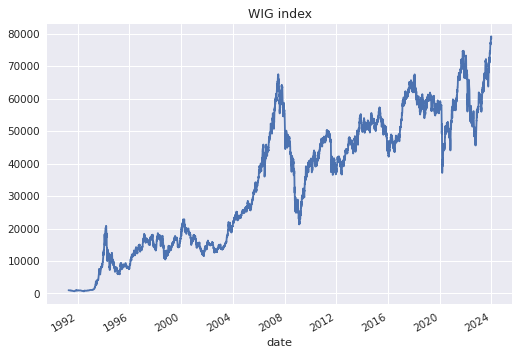

In [11]:
# Third, visualize the 'close' column
raw['close'].plot(title='WIG index');

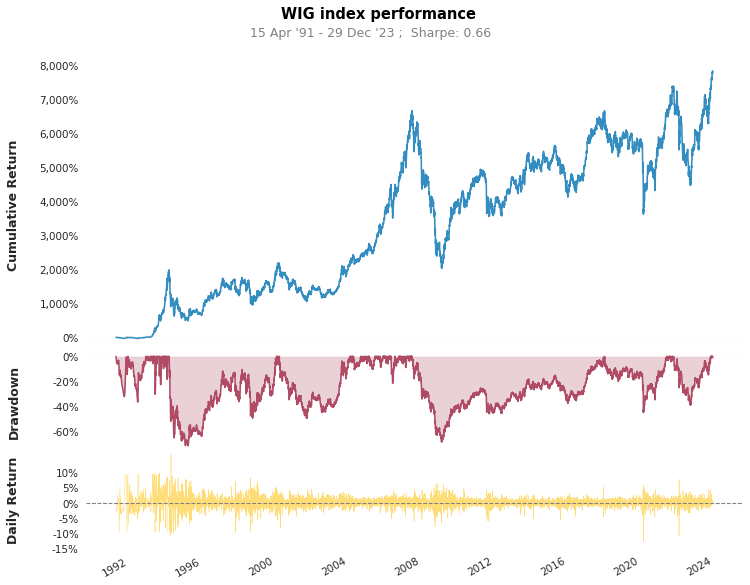

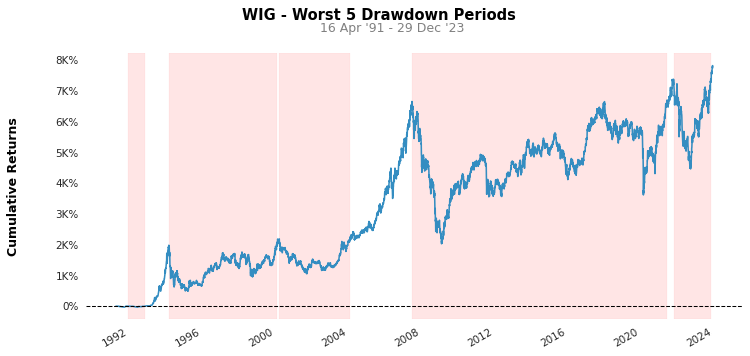

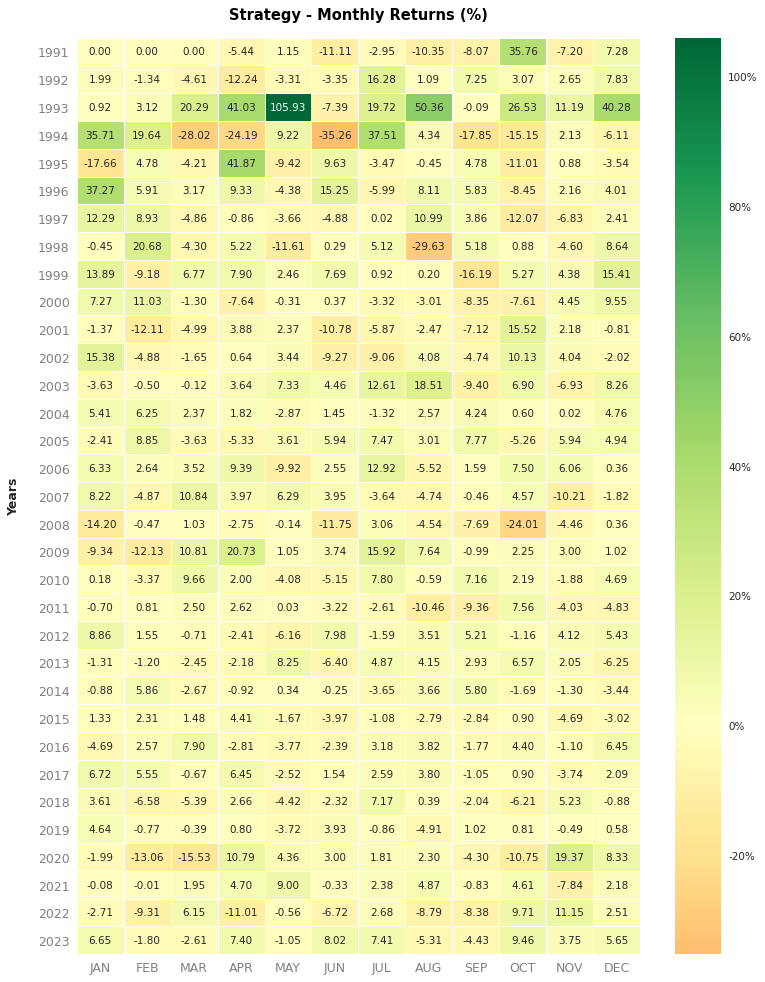

In [12]:
# Let's utilise quantstats library capabilities for some further EDA
qs.plots.snapshot(raw['close'], title='WIG index performance', fontname='sans-serif')
qs.plots.drawdowns_periods(raw['close'], title='WIG', fontname='sans-serif')
qs.plots.monthly_heatmap(raw['close'], fontname='sans-serif')

## Simple linear regression

In [13]:
# Convert the raw data into a DataFrame object, drop all columns except for the 'close' column (closing price)
# Make a copy of the DataFrame
df = pd.DataFrame(raw).drop(['open', 'high', 'low'], axis=1)
df1 = df.copy()

In [14]:
# Add some lagged values of the 'close' column to the DataFrame
# Drop any 'na' values created during the process 
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    df1[col] = df1['close'].shift(lag)
    cols.append(col)
df1.dropna(inplace=True)

In [15]:
# Perform a linear regression (target = close, predictors = lagged close)
# Print the fitted regression parameters
lin_reg = np.linalg.lstsq(df1[cols], df1['close'], rcond=None)[0]
lin_reg.round(2)

array([ 1.06, -0.08,  0.06, -0.02, -0.01])

In [16]:
# Add the model's predictions to the DataFrame
df1['prediction'] = np.dot(df1[cols], lin_reg)

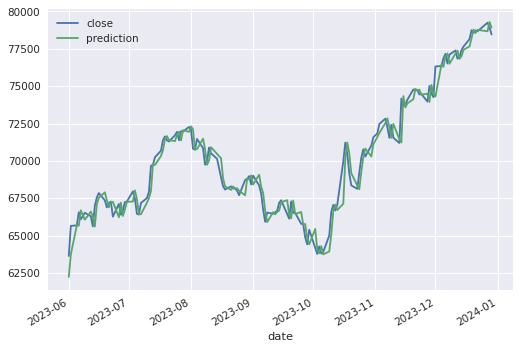

In [17]:
# Plot the index level vs the model predicted level
df1[['close', 'prediction']].loc['2023-06-01':].plot();

## Index return prediction

In [18]:
# Make a copy of the raw data
# Calculate the daily log returns
# Drop the na value created in the process
df2 = df.copy()
df2['index_return'] = np.log(df2['close'] / df2['close'].shift(1))
df2.dropna(inplace=True)

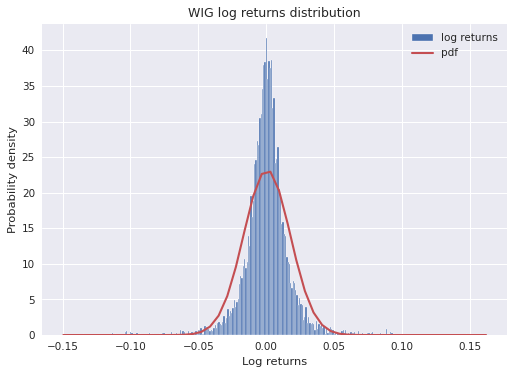

In [19]:
# Plot a histogram of daily log returns against a normal pdf curve
# The realized returns obviously do not follow a normal distribution
plt.hist(df2['index_return'], bins=300, density=True, label='log returns')
plt.xlabel('Log returns')
plt.ylabel('Probability density')
plt.title('WIG log returns distribution')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, df2['index_return'].mean(), df2['index_return'].std()), 'r', lw=2.0, label='pdf')
plt.legend();

In [20]:
# Add 5 lagged values of the 'index_return' column to the DataFrame
# Drop any 'na' values created during the process 
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    df2[col] = df2['index_return'].shift(lag)
    cols.append(col)
df2.dropna(inplace=True)

In [21]:
# Perform a linear regression (target = log daily return, predictors = lagged log daily returns)
# Print the fitted regression parameters
lin_reg = np.linalg.lstsq(df2[cols], df2['index_return'], rcond=None)[0]
lin_reg.round(2)

array([ 0.23, -0.06,  0.03,  0.03,  0.01])

In [22]:
# Add the model's predictions to the DataFrame
df2['prediction'] = np.dot(df2[cols], lin_reg)

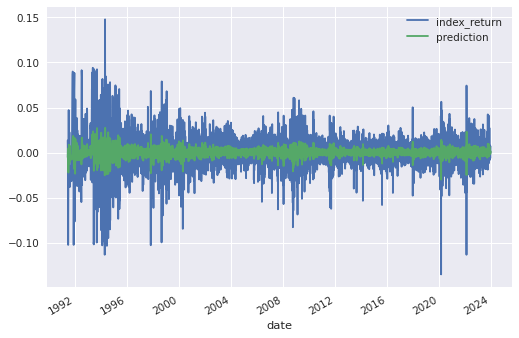

In [23]:
# Plot the index realized return vs the model predicted return
df2[['index_return', 'prediction']].plot();

In [24]:
# Calculate a 'hits' ratio (% of correct index direction predictions)
hits = np.sign(df2['index_return'] * df2['prediction']).value_counts()
hits.values[0] / sum(hits)

0.5267926482008801

## Index direction prediction (linear regression)

In [25]:
# Make a copy of the raw data
# Calculate the daily log returns
# Drop the na value created in the process
df3 = df.copy()
df3['index_return'] = np.log(df3['close'] / df3['close'].shift(1))
df3.dropna(inplace=True)

In [26]:
# Add 5 lagged values of the 'index_return' column to the DataFrame
# Drop any 'na' values created during the process 
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    df3[col] = df3['index_return'].shift(lag)
    cols.append(col)
df3.dropna(inplace=True)

In [27]:
# Build a linear regression model (target = sign of log daily return, predictors = lagged log daily returns)
# Print the fitted regression parameters
lin_reg = np.linalg.lstsq(df3[cols], np.sign(df3['index_return']), rcond=None)[0]
lin_reg.round(2)

array([ 5.36, -2.08,  0.22,  1.06,  0.29])

In [28]:
# Add the model's predictions to the DataFrame
df3['prediction'] = np.sign(np.dot(df3[cols], lin_reg))
df3['prediction'].value_counts()

prediction
 1.0    3957
-1.0    3769
Name: count, dtype: int64

In [29]:
# Calculate a 'hits' ratio (% of correct index direction predictions)
hits = np.sign(df3['index_return'] * df3['prediction']).value_counts()
hits.values[0] / sum(hits)

0.529510742945897

## Vectorized backtest

In [30]:
# Calculate the 'strategy return' - return realized if investing in the index based on the model's predictions (no transaction costs) 
df3['strategy_return'] = df3['prediction'] * df3['index_return']
df3[['index_return', 'strategy_return']].sum().apply(np.exp)

index_return       8.202813e+01
strategy_return    2.844236e+06
dtype: float64

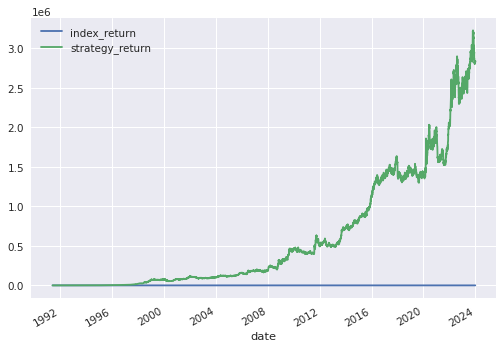

In [31]:
# Plot cumulative returns of the strategy vs the index return
df3[['index_return', 'strategy_return']].dropna().cumsum().apply(np.exp).plot();

## Index direction prediction (logistic regression)

In [32]:
# Make a copy of the raw data
# Calculate the daily log returns
# Drop the na value created in the process
df4 = df.copy()
df4['index_return'] = np.log(df4['close'] / df4['close'].shift(1))
df4.dropna(inplace=True)

In [33]:
# Add 5 lagged values of the 'index_return' column to the DataFrame
# Drop any 'na' values created during the process 
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    df4[col] = df4['index_return'].shift(lag)
    cols.append(col)
df4.dropna(inplace=True)

In [34]:
# Instantiate a logistic regression model
log_reg = linear_model.LogisticRegression(C=1e7, solver='lbfgs', multi_class='auto', max_iter=1000)

In [35]:
# Perform a logistic regression (target = log daily return, predictors = lagged log daily returns)
log_reg.fit(df4[cols], np.sign(df4['index_return']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [36]:
# Add the model's predictions to the DataFrame
df4['prediction'] = log_reg.predict(df4[cols])
df4['prediction'].value_counts()

prediction
 1.0    5770
-1.0    1956
Name: count, dtype: int64

In [37]:
# Calculate a 'hits' ratio (% of correct index direction predictions)
hits = np.sign(df4['index_return'] * df4['prediction']).value_counts()
hits.values[0] / sum(hits)

0.5358529640176029

In [38]:
# Calculate accuracy_score metric
accuracy_score(df4['prediction'], np.sign(df4['index_return']))

0.5358529640176029

In [39]:
# Calculate the 'strategy return' - return realized if investing in the index based on the model's predictions (no transaction costs) 
df4['strategy_return'] = df4['prediction'] * df4['index_return']
df4[['index_return', 'strategy_return']].sum().apply(np.exp)

index_return       8.202813e+01
strategy_return    4.189164e+06
dtype: float64

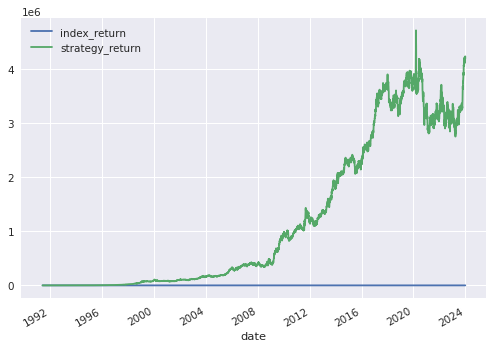

In [40]:
# Plot a cumulative returns of the strategy vs the index
df4[['index_return', 'strategy_return']].dropna().cumsum().apply(np.exp).plot();

## Index direction prediction (deep neural network)

In [41]:
# Make a copy of the raw data
# Calculate the daily log returns
# Drop the na value created in the process
df5 = df.copy()
df5['index_return'] = np.log(df5['close'] / df5['close'].shift(1))
df5.dropna(inplace=True)

In [42]:
# Convert daily log returns into 0 (negative return) or 1 (positive return) 
df5['direction'] = np.where(df5['index_return'] > 0, 1, 0)

In [43]:
# Add 5 lagged values of the 'index_return' column to the DataFrame
# Drop any 'na' values created during the process
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    df5[col] = df5['index_return'].shift(lag)
    cols.append(col)
df5.dropna(inplace=True)

In [44]:
df5.shape

(7726, 8)

In [45]:
# Perform a train/val/test split
# Assume 80% of the dataset used for training, 20% of the dataset used for testing, 10% of the training dataset used for validation
x_train, x_test, y_train, y_test = train_test_split(df5, df5, test_size=0.2, random_state=100, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=100, shuffle=False)

print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Shape of x_val: ", x_val.shape)
print("Shape of y_val: ", y_val.shape)

Shape of x_train:  (5562, 8)
Shape of y_train:  (5562, 8)
Shape of x_test:  (1546, 8)
Shape of y_test:  (1546, 8)
Shape of x_val:  (618, 8)
Shape of y_val:  (618, 8)


In [46]:
print(len(x_train) + len(x_val) + len(x_test))
print(len(y_train) + len(y_val) + len(y_test))

7726
7726


## A simple DNN

In [47]:
# Let's start with 1 hidden layer, 32 neurons, ReLU activation
set_seeds()
model = Sequential()
model.add(Dense(32, activation="relu", input_shape=(len(cols),)))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
model.fit(x_train[cols], x_train['direction'], epochs = 25, verbose=False, shuffle=False)

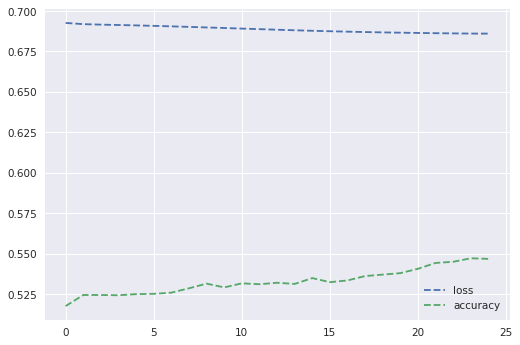

In [48]:
res = pd.DataFrame(model.history.history)
res[['loss', 'accuracy']].plot(style='--');

In [49]:
model.evaluate(x_train[cols], x_train['direction'])

174/174 [==============================] - 1s 2ms/step - loss: 0.6851 - accuracy: 0.5502


[0.6851018667221069, 0.5501618385314941]

In [50]:
pred = np.where(model.predict(x_train[cols]) > 0.5, 1, 0)

174/174 [==============================] - 0s 2ms/step


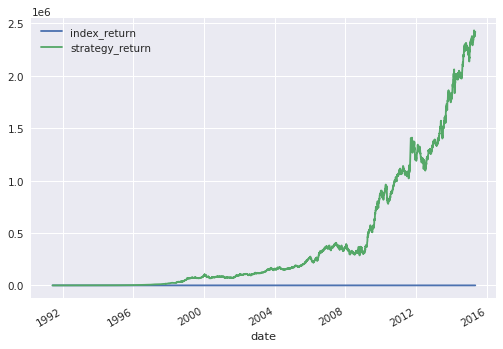

In [51]:
x_train['prediction'] = np.where(pred > 0, 1, -1)
x_train['strategy_return'] = (x_train['prediction'] * x_train['index_return'])
x_train[['index_return', 'strategy_return']].cumsum().apply(np.exp).plot();

In [52]:
model.evaluate(x_test[cols], x_test['direction'])

49/49 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5071


[0.6953163146972656, 0.5071151256561279]

In [53]:
test_scores = model.evaluate(x_test[cols], x_test['direction'], verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

49/49 - 0s - loss: 0.6953 - accuracy: 0.5071 - 114ms/epoch - 2ms/step
Test loss: 0.6953163146972656
Test accuracy: 0.5071151256561279


In [54]:
pred = np.where(model.predict(x_test[cols]) > 0.5, 1, 0)

49/49 [==============================] - 0s 2ms/step


In [55]:
x_test['prediction'] = np.where(pred > 0, 1, -1)
x_test['prediction'].value_counts()

prediction
 1    1194
-1     352
Name: count, dtype: int64

In [56]:
x_test['strategy_return'] = (x_test['prediction'] * x_test['index_return'])
x_test[['index_return', 'strategy_return']].sum().apply(np.exp)

index_return       1.231425
strategy_return    1.186141
dtype: float64

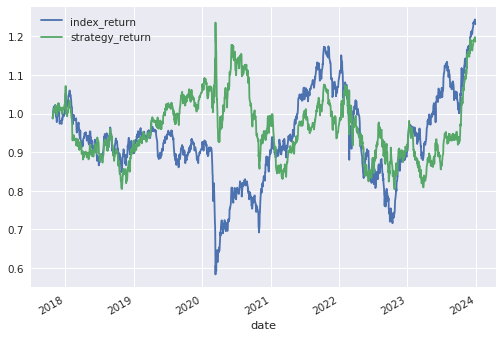

In [57]:
x_test[['index_return', 'strategy_return']].cumsum().apply(np.exp).plot();

## A simple DNN - additional features

In [58]:
df5['mom'] = df5['index_return'].rolling(5).mean().shift(1)
df5['vol'] = df5['index_return'].rolling(20).std().shift(1)
df5['dis'] = (df5['close'] - df5['close'].rolling(50).mean()).shift(1)
df5.dropna(inplace=True)
cols.extend(['mom', 'vol', 'dis'])

In [59]:
# Perform a train/val/test split
# Assume 80% of the dataset used for training, 20% of the dataset used for testing, 10% of the training dataset used for validation
x_train, x_test, y_train, y_test = train_test_split(df5, df5, test_size=0.2, random_state=100, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=100, shuffle=False)

In [60]:
# 2 hidden layers, 32 neurons each, ReLU activation
set_seeds()
model = Sequential()
model.add(Dense(32, activation="relu", input_shape=(len(cols),)))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
model.fit(x_train[cols], x_train['direction'], epochs = 50, verbose=False, shuffle=False)

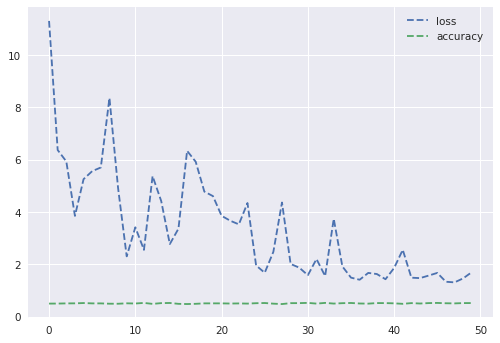

In [61]:
res = pd.DataFrame(model.history.history)
res[['loss', 'accuracy']].plot(style='--');

In [62]:
model.evaluate(x_train[cols], x_train['direction'])

173/173 [==============================] - 0s 2ms/step - loss: 1.7044 - accuracy: 0.4900


[1.7044377326965332, 0.49004703760147095]

In [63]:
pred = np.where(model.predict(x_train[cols]) > 0.5, 1, 0)

173/173 [==============================] - 0s 2ms/step


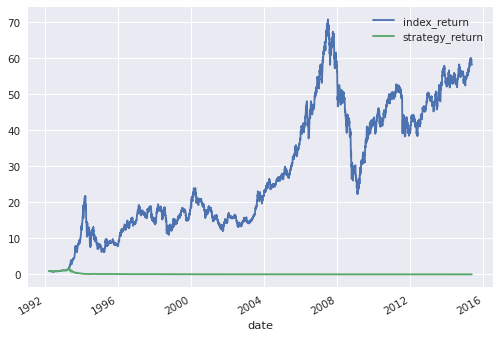

In [64]:
x_train['prediction'] = np.where(pred > 0, 1, -1)
x_train['strategy_return'] = (x_train['prediction'] * x_train['index_return'])
x_train[['index_return', 'strategy_return']].cumsum().apply(np.exp).plot();

In [65]:
model.evaluate(x_test[cols], x_test['direction'])

48/48 [==============================] - 0s 2ms/step - loss: 3.0308 - accuracy: 0.4831


[3.030824661254883, 0.4830729067325592]

In [66]:
test_scores = model.evaluate(x_test[cols], x_test['direction'], verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

48/48 - 0s - loss: 3.0308 - accuracy: 0.4831 - 101ms/epoch - 2ms/step
Test loss: 3.030824661254883
Test accuracy: 0.4830729067325592


In [67]:
pred = np.where(model.predict(x_test[cols]) > 0.5, 1, 0)

48/48 [==============================] - 0s 1ms/step


In [68]:
x_test['prediction'] = np.where(pred > 0, 1, -1)
x_test['prediction'].value_counts()

prediction
-1    781
 1    755
Name: count, dtype: int64

In [69]:
x_test['strategy_return'] = (x_test['prediction'] * x_test['index_return'])
x_test[['index_return', 'strategy_return']].sum().apply(np.exp)

index_return       1.204587
strategy_return    0.487658
dtype: float64

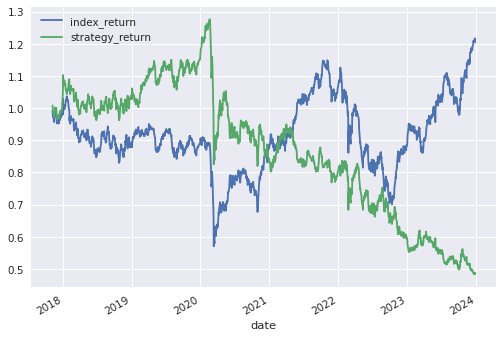

In [70]:
x_test[['index_return', 'strategy_return']].cumsum().apply(np.exp).plot();